In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
dataset = load_dataset("ag_news")
df_test = pd.DataFrame(dataset['test'])
df_train = pd.DataFrame(dataset['train'])
df_train = df_train.groupby('label').apply(lambda x: x.sample(n=4000)).reset_index(drop=True)
df_train = pd.concat([df_train, df_test], axis=0)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
df_train # 16000+7600

,text,label
0,Mixed Reaction Among Iraqis Following US Serge...,0
1,"Shunned, India's untouchables gather tsunami d...",0
2,"Inside the Imam Ali shrine, as US closes in Th...",0
3,Republicans Aim to Show Party Diversity (AP) A...,0
4,US volcano eruption 'imminent' A tremor at Mou...,0
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers, optimizers
from keras.preprocessing import text, sequence
from keras.optimizers import SGD

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df_train['text']))
tokenized_texts = tokenizer.texts_to_sequences(df_train['text'])
X = pad_sequences(tokenized_texts, maxlen=100)

In [ ]:
y = pd.get_dummies(df_train["label"]).values

In [ ]:
X

array([[    0,     0,     0, ...,  1637,  3546,   920],
       [    0,     0,     0, ...,  2397,  4501,  3254],
       [    0,     0,     0, ...,     4,  3634, 14823],
       ...,
       [    0,     0,     0, ...,  4364,    18,   546],
       [    0,     0,     0, ...,   430,    60,    33],
       [    0,     0,     0, ...,   738,     4,  4007]], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state = 42)

In [ ]:
y_train

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize
data = df_train['text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)

In [ ]:
model = Sequential()
embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(128, return_sequences=True))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
adam = optimizers.Adam(learning_rate = 0.001)
#opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         5775488   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         197120    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
history =model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
126/126 [==============================] - 17s 37ms/step - loss: 0.5966 - accuracy: 0.7643 - val_loss: 0.3518 - val_accuracy: 0.8856
Epoch 2/10
126/126 [==============================] - 3s 24ms/step - loss: 0.2024 - accuracy: 0.9362 - val_loss: 0.3777 - val_accuracy: 0.8815
Epoch 3/10
126/126 [==============================] - 3s 24ms/step - loss: 0.1000 - accuracy: 0.9715 - val_loss: 0.4666 - val_accuracy: 0.8680
Epoch 4/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0749 - accuracy: 0.9781 - val_loss: 0.5995 - val_accuracy: 0.8713
Epoch 5/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0506 - accuracy: 0.9857 - val_loss: 0.5383 - val_accuracy: 0.8709
Epoch 6/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0396 - accuracy: 0.9888 - val_loss: 0.6197 - val_accuracy: 0.8611
Epoch 7/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0294 - accuracy: 0.9924 - val_loss: 0.6621 - val_accuracy: 0.868

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

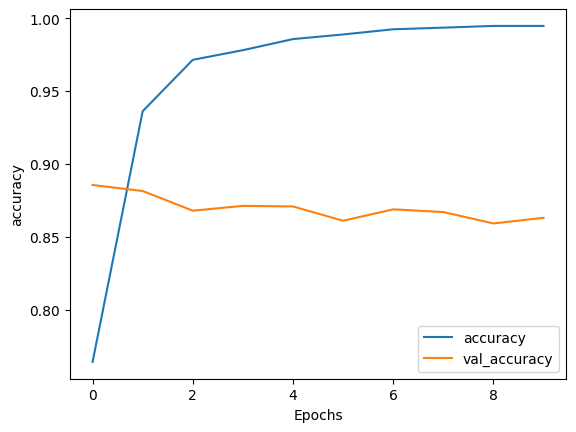

In [ ]:
plot_graphs(history, "accuracy")

In [ ]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

236/236 [==============================] - 3s 8ms/step


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
precision, recall, fscore, support= score(y_true, y_pred)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 score: {}".format(fscore))
print("Support: {}".format(support))
print("Accuracy score:{}".format(accuracy_score(y_true, y_pred)))

Precision: [0.88142077 0.93635383 0.82112527 0.81754032]
Recall: [0.84984194 0.9338354  0.81207349 0.85820106]
F1 score: [0.86534335 0.93509292 0.81657429 0.83737739]
Support: [1898 1859 1905 1890]
Accuracy score:0.863082627118644


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1898
           1       0.94      0.93      0.94      1859
           2       0.82      0.81      0.82      1905
           3       0.82      0.86      0.84      1890

    accuracy                           0.86      7552
   macro avg       0.86      0.86      0.86      7552
weighted avg       0.86      0.86      0.86      7552

[[1613   62  152   71]
 [  46 1736   40   37]
 [  70   34 1547  254]
 [ 101   22  145 1622]]
